In [25]:
import numpy as np # 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor as RFR

In [3]:
# 파일불러오기
df = pd.read_csv('./Location1.csv')
df.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [4]:
#화씨온도를 섭씨온도로 변환
df['temperature_2m'] = round((df['temperature_2m'] - 32) * 5/9,2)
df['dewpoint_2m'] = round((df['dewpoint_2m'] - 32) * 5/9,2)

In [5]:
#시간에 따른 발전량 변화 분석
#'Time' 컬럼을 기반으로 시계열 그래프를 생성하여 시간에 따른 발전량의 변화를 시각적으로 확인하세요. 발전량의 일일, 주간, 월간 패턴 등을 살펴보세요.
# 일간
df_day = df.copy()
df_day['Time'] = df_day['Time'].str[:10]
#월간
df_month = df.copy()
df_month['Time'] = df_month['Time'].str[:7]
#연간
df_year = df.copy()
df_year['Time'] = df_year['Time'].str[:4]

In [8]:
df_day.columns

Index(['Time', 'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power'],
      dtype='object')

In [6]:
df_dm =df_day.groupby(['Time']).agg('mean').reset_index()

In [7]:
df_dm['Time'] = pd.to_datetime(df_dm['Time'])
df_dm.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02,0.264167,86.041667,-1.860833,2.635417,4.937083,91.791667,102.125000,5.391667,0.194150
1,2017-01-03,2.688750,98.833333,2.505833,2.413333,4.348333,160.250000,171.833333,5.033333,0.230358
2,2017-01-04,-6.678750,63.208333,-12.794167,7.679167,12.374583,270.125000,272.000000,15.987500,0.868033
3,2017-01-05,-11.977083,58.125000,-18.619583,4.898333,8.497917,254.750000,259.208333,10.387500,0.698042
4,2017-01-06,-14.650417,62.708333,-20.323333,3.430000,6.977917,248.041667,255.291667,6.762500,0.322771


In [8]:
df_dm = df_dm.drop('Time',axis =1)

In [11]:
scaler = StandardScaler()
x = df_dm[df_dm.columns.difference(['Power'])]
y = df_dm['Power']
x_scaled = scaler.fit_transform(x)

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y, test_size=0.3,random_state=123)

In [29]:
y_train.value_counts(normalize=True)

0.278508    0.001566
0.537583    0.001566
0.585658    0.001566
0.591621    0.000783
0.216625    0.000783
              ...   
0.051838    0.000783
0.780863    0.000783
0.246225    0.000783
0.640250    0.000783
0.076400    0.000783
Name: Power, Length: 1274, dtype: float64

In [35]:
def optimi_estimator(algorithm, algorithm_name,x_train,y_train, x_test,y_test,n_estimator_min,n_estimator_max):
    train_score =[]; test_score =[]
    para_n_tree =[n_tree*5 for n_tree in range(n_estimator_min,n_estimator_max)]
    
    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators,random_state =1234)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train,y_train))
        test_score.append(model.score(x_test,y_test))
    
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree,'TrainScore': train_score,'TestScore': test_score})
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator")
    print(round(df_score_n,4))
    

In [40]:
def optimi_maxdepth(algorithm,algorithm_name,x_train,y_train,x_test,y_test,depth_min,depth_max,n_estimator):
    train_score =[]; test_score=[]
    para_depth = [depth for depth in range(depth_min, depth_max)]
    
    for v_max_depth in para_depth:
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                             random_state = 1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                             n_estimators = n_estimator,
                             random_state = 1234)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train,y_train))
        test_score.append(model.score(x_test,y_test))
        
        df_score_n = pd.DataFrame({'depth': para_depth,'TrainScore': train_score,'TestScore':test_score})
        #df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
        optimi_visualization(algorithm_name,para_depth,train_score,test_score,'The number of depth')
        print(round(df_score_n,4))
        
        

In [100]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth")
    print(round(df_score_n, 4))

In [42]:
def optimi_minsplit(algorithm,algorithm_name,x_train,y_train,x_test,y_test,n_split_min,n_split_max,n_estimator,n_depth):
    train_score =[]; test_score=[]
    para_split = [n_split*2 for n_split in range(n_split_min,n_split_max)]
    
    for v_min_samples_split in para_split:
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                             random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                             n_estimators = n_estimator,
                              max_depth = n_depth,
                             random_state = 1234)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train,y_train))
        test_score.append(model.score(x_test,y_test))
        
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node")
    print(round(df_score_n,4))
   
        
        

In [51]:
def optimi_minleaf(algorithm,algorithm_name,x_train,y_train,x_test,y_test,n_leaf_min,n_leaf_max,n_estimator,n_depth,n_split):
    train_score =[]; test_score=[]
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min,n_leaf_max)]
    
    for v_min_samples_leaf in para_leaf:
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                             max_depth = n_depth,
                             min_samples_split = n_split,
                             random_state = 1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                              n_estimators = n_estimator,
                             max_depth = n_depth,
                             min_samples_split = n_split,
                             random_state = 1234)
        model.fit(x_train,y_train)
        train_score.append(model.score(x_train,y_train))
        test_score.append(model.score(x_test,y_test))
        
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf,'TrainScore': train_score,'TestScore':test_score})
    optimi_visualization(algorithm_name,para_leaf,train_score,test_score,' "The minimum number leaf"')
    print(round(df_score_n,4))
        
        

In [44]:
def model_final(algorithm,algorithm_name,x_train,y_train,x_test,y_test,n_estimator,n_depth,n_split,n_leaf):
    if algorithm == DTC:
        model =algorithm(random_state = 1234,
                        min_samples_leaf = n_leaf,
                        min_samples_split = n_split,
                        max_depth = n_depth)
    else :
        model = algorithm(random_state= 1234,
                        min_samples_leaf = n_leaf,
                        min_samples_split = n_split,
                        n_estimators = n_estimator,
                        max_depth = n_depth)
    model.fit(x_train,y_train)
    
    train_acc = model.score(x_train,y_train)
    test_acc = model.score(x_test,y_test)
    y_pred = model.predict(x_test)    
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.3f}')
    
        
    df_score_n = pd.DataFrame({'y_test': y_test,'y_pred': y_pred})
    print(round(df_score_n,4))

In [40]:
from sklearn.ensemble import RandomForestRegressor as RFR # 랜덤포레스트 분류 알고리즘

In [27]:
algorithm = RFR
algorithm_name = 'rfr'

In [65]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.gcf().set_size_inches(8,3)
    #plt.savefig('./' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장

In [38]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.mean_squared_error(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.mean_squared_error(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

    n_estimators  TrainScore  TestScore
0              5      0.9375     0.7401
1             10      0.9593     0.7683
2             15      0.9627     0.7775
3             20      0.9644     0.7801
4             25      0.9662     0.7838
5             30      0.9674     0.7847
6             35      0.9678     0.7872
7             40      0.9681     0.7890
8             45      0.9686     0.7880
9             50      0.9687     0.7892
10            55      0.9690     0.7889
11            60      0.9693     0.7888
12            65      0.9697     0.7898
13            70      0.9700     0.7896
14            75      0.9701     0.7884
15            80      0.9702     0.7880
16            85      0.9700     0.7894
17            90      0.9701     0.7899
18            95      0.9703     0.7903
19           100      0.9702     0.7907
20           105      0.9702     0.7907
21           110      0.9705     0.7908
22           115      0.9706     0.7911
23           120      0.9706     0.7915


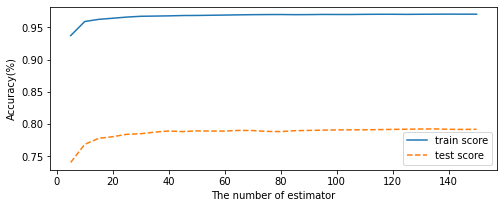

In [66]:
n_estimator_min = 1
n_estimator_max = 31
optimi_estimator(algorithm,algorithm_name,
                x_train,y_train,x_test,y_test,
                n_estimator_min,n_estimator_max)

In [73]:
modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test)

학습 데이터셋 정확도: 0.97
테스트 데이터셋 정확도: 0.791


(0.97, 0.791)

In [45]:
n_estimator=30

    depth  TrainScore  TestScore
0       1      0.6683     0.6574
1       2      0.7898     0.7871
2       3      0.8109     0.7990
3       4      0.8308     0.8003
4       5      0.8529     0.7981
5       6      0.8761     0.7981
6       7      0.8989     0.7956
7       8      0.9175     0.7927
8       9      0.9325     0.7899
9      10      0.9445     0.7878
10     11      0.9528     0.7851
11     12      0.9586     0.7873
12     13      0.9625     0.7879
13     14      0.9646     0.7861
14     15      0.9662     0.7860
15     16      0.9665     0.7873
16     17      0.9667     0.7852
17     18      0.9669     0.7821
18     19      0.9674     0.7819
19     20      0.9672     0.7847


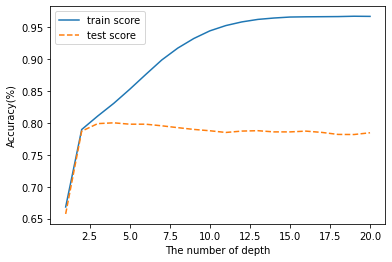

In [46]:
depth_min = 1
depth_max = 21
optimi_maxdepth(algorithm,algorithm_name,
                x_train,y_train,x_test,y_test,
                depth_min,depth_max,n_estimator)

In [47]:
n_depth = 4

    min_samples_split  TrainScore  TestScore
0                   2      0.8308     0.8003
1                   4      0.8306     0.8003
2                   6      0.8305     0.8002
3                   8      0.8305     0.8002
4                  10      0.8305     0.8002
5                  12      0.8305     0.8002
6                  14      0.8305     0.8002
7                  16      0.8305     0.8002
8                  18      0.8300     0.8001
9                  20      0.8300     0.8001
10                 22      0.8298     0.8000
11                 24      0.8296     0.8001
12                 26      0.8294     0.8002
13                 28      0.8293     0.8002
14                 30      0.8293     0.8002
15                 32      0.8293     0.8002
16                 34      0.8293     0.8003
17                 36      0.8290     0.8005
18                 38      0.8290     0.8005
19                 40      0.8288     0.8005
20                 42      0.8288     0.8005
21        

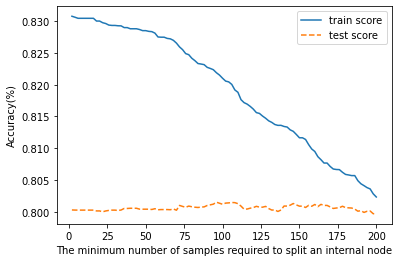

In [48]:
n_split_min = 1
n_split_max = 101
pd.set_option('display.max_row',100)
optimi_minsplit(algorithm,algorithm_name,
               x_train,y_train,x_test,y_test,
               n_split_min,n_split_max,n_estimator,n_depth)

In [49]:
n_split = 200

    min_samples_leaf  TrainScore  TestScore
0                  2      0.8023     0.7996
1                  4      0.8023     0.7996
2                  6      0.8023     0.7996
3                  8      0.8023     0.7997
4                 10      0.8023     0.7997
5                 12      0.8023     0.7997
6                 14      0.8023     0.7997
7                 16      0.8023     0.7997
8                 18      0.8023     0.7997
9                 20      0.8023     0.7997
10                22      0.8022     0.7997
11                24      0.8022     0.7997
12                26      0.8022     0.7997
13                28      0.8022     0.7997
14                30      0.8022     0.7997
15                32      0.8022     0.7997
16                34      0.8022     0.7997
17                36      0.8022     0.7997
18                38      0.8022     0.7997
19                40      0.8022     0.7997
20                42      0.8022     0.7997
21                44      0.8022

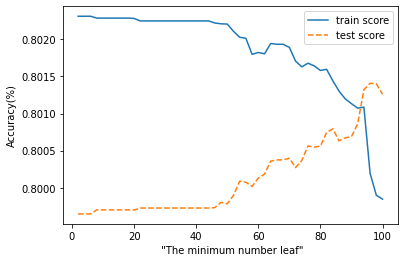

In [52]:
n_leaf_min=1
n_leaf_max = 51
optimi_minleaf(algorithm,algorithm_name,
              x_train,y_train,x_test,y_test,
              n_leaf_min,n_leaf_max,n_estimator,n_depth,n_split)

In [53]:
n_leaf = 92

In [37]:
from sklearn.metrics import mean_squared_error

In [54]:
model_final(algorithm,algorithm_name,
           x_train,y_train,x_test,y_test,
           n_estimator,n_depth,n_split,n_leaf)

Mean Squared Error: 0.011
      y_test  y_pred
772   0.6611  0.7618
947   0.0339  0.1295
1551  0.2799  0.2568
1656  0.0921  0.1885
28    0.3609  0.2802
...      ...     ...
302   0.5557  0.6852
1179  0.3960  0.4769
909   0.1503  0.1693
1628  0.6212  0.5852
98    0.7073  0.7618

[548 rows x 2 columns]


In [59]:
def modeling_uncustomized (algorithm,x_train,y_train,x_test,y_test):
    uncustomized = algorithm(random_state =1234)
    uncustomized.fit(x_train,y_train)
    train_score_before = mean_squared_error(x_train,y_train).round(3)
    print(f"학습 데이터셋 정확도 :{train_score_before}")
    test_score_before =mean_squared_error(x_test,y_test).round(3)
    return train_score_before,test_score_before

In [62]:
modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test)

학습 데이터셋 정확도: 0.002
테스트 데이터셋 정확도: 0.012


(0.002, 0.012)

In [64]:
modeling_customized (algorithm, x_train, y_train, x_test, y_test)

학습 데이터셋 정확도: 0.012
테스트 데이터셋 정확도: 0.011


(0.012, 0.011)

In [61]:
def modeling_uncustomized(algorithm, x_train, y_train, x_test, y_test):
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    
    # 모델 예측
    y_pred_train = uncustomized.predict(x_train)
    y_pred_test = uncustomized.predict(x_test)
    
    # 평가 지표 계산
    train_score_before = mean_squared_error(y_train, y_pred_train).round(3)
    test_score_before = mean_squared_error(y_test, y_pred_test).round(3)
    
    print(f"학습 데이터셋 정확도: {train_score_before}")
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    
    return train_score_before, test_score_before


In [63]:
def modeling_customized(algorithm, x_train, y_train, x_test, y_test):
    uncustomized = algorithm(random_state=1234,
                             n_estimators=30,
                             max_depth=4,
                             min_samples_split=200,
                             min_samples_leaf=92)
    uncustomized.fit(x_train, y_train)
    
    # 모델 예측
    y_pred_train = uncustomized.predict(x_train)
    y_pred_test = uncustomized.predict(x_test)
    
    # 평가 지표 계산
    train_score_before = mean_squared_error(y_train, y_pred_train).round(3)
    test_score_before = mean_squared_error(y_test, y_pred_test).round(3)
    
    print(f"학습 데이터셋 정확도: {train_score_before}")
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    
    return train_score_before, test_score_before


Mean Squared Error: 0.011
      y_test  y_pred
0     0.1942  0.2568
5     0.5698  0.5826
12    0.1088  0.1375
13    0.1029  0.1556
15    0.3999  0.4817
...      ...     ...
1815  0.8071  0.7618
1817  0.8653  0.5051
1818  0.4652  0.3774
1822  0.2020  0.3053
1824  0.2032  0.2350

[548 rows x 2 columns]


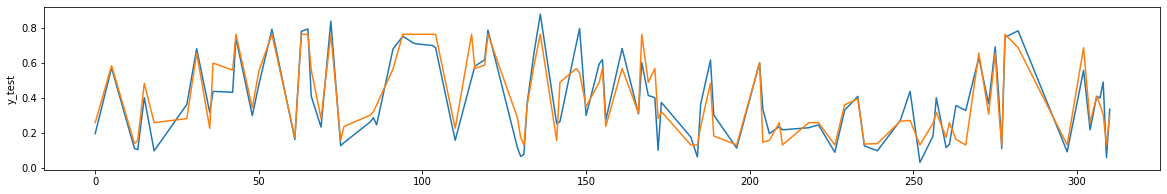

In [99]:
model_final(algorithm,algorithm_name,
           x_train,y_train,x_test,y_test,
           n_estimator,n_depth,n_split,n_leaf)

In [98]:
def model_final(algorithm,algorithm_name,x_train,y_train,x_test,y_test,n_estimator,n_depth,n_split,n_leaf):
    if algorithm == DTC:
        model =algorithm(random_state = 1234,
                        min_samples_leaf = n_leaf,
                        min_samples_split = n_split,
                        max_depth = n_depth)
    else :
        model = algorithm(random_state= 1234,
                        min_samples_leaf = n_leaf,
                        min_samples_split = n_split,
                        n_estimators = n_estimator,
                        max_depth = n_depth)
    model.fit(x_train,y_train)
    
    y_pred = model.predict(x_test)    
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.3f}')
       
    df_score_n = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_score_n = df_score_n.sort_index(ascending=True)
    plt.figure(figsize = (20,3))
    sns.lineplot(data = df_score_n[:100],x= df_score_n[:100].index,y = 'y_test')
    sns.lineplot(data = df_score_n[:100],x= df_score_n[:100].index,y = 'y_pred')

    print(round(df_score_n,4))

In [97]:
import seaborn as sns